## ** To be integrated with other notebook?

In [1]:
from allensdk.brain_observatory.drifting_gratings import DriftingGratings
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = '../data/allen-brain-observatory/visual-coding-2p/manifest.json'
boc = BrainObservatoryCache(manifest_file=manifest_file)

In [2]:
cell1_id = 541513979
cell2_id = 541513083
exps = boc.get_ophys_experiments(cell_specimen_ids=[cell1_id], stimuli=['drifting_gratings'])
session_id = exps[0]['id']
data_set = boc.get_ophys_experiment_data(session_id)

cells = data_set.get_cell_specimen_indices([cell1_id, cell2_id])

In [3]:
dg = DriftingGratings(data_set)

In [4]:

mean_sweep_response = dg.mean_sweep_response
mean_sweep_response = mean_sweep_response.drop(columns=['dx'])
mean_sweep_response.columns = mean_sweep_response.columns.astype(int)

stim_table = dg.stim_table
mean_sweep_response = mean_sweep_response[stim_table['blank_sweep'] == False]
stim_table = stim_table[stim_table['blank_sweep'] == False]

To understand the responses of the *population* of cells in this session, we'll first simplify things by isolating the stimuli for a particular temporal frequency.

In [43]:
# Ex:
# Use the information in the stimulus table to select a subset of responses at a particular temporal frequency

selected_sweeps = (stim_table['temporal_frequency'] == 2.0)
selected_responses = mean_sweep_response[selected_sweeps]

## Classification problems

We are going to use some basic machine learning to solve a *classification* problem based on this data: given the responses of a set of cells on a given trial (start with two), can we predict the stimulus orientation of that trial? 

We'll start by simplifying to a *binary classification*, predicting whether the orientation is 0 versus any other orientation.

The conventional notation for this type of problem is to represent the data feature matrix by a variable `X` (capital to indicate a 2D matrix, with each column a distinct feature and each row a sample) and the target data by a variable `y` (lowercase to indicate a 1D vector). We'll first initialize these variables.



In [44]:
cells_index = [5, 30]
# Create a binary indicator for orientation == 0
y = (stim_table.loc[selected_sweeps, 'orientation'] == 0).astype(int)
X = selected_responses.loc[:, cells_index]
X.shape

(120, 2)

## Fitting and prediction in scikit-learn

We'll use the package scikit-learn (sklearn), which is a popular and powerful machine learning package in Python. One strength of this package is a simple interface (pattern of use) for a variety of different machine learning tools, or *estimators*. It follows an *object-oriented* approach - each estimator is a Python class which must first be initialized, then passed data to fit and make predictions from.

This pattern can be used for different types of problems: *classification* when the target is categorical, *regression* when the target is continuous, or even *unsupervised* problems where there is no target data to train on. Chains of estimators can even be combined into *pipelines* that can be used in the same way. 

In [45]:

from sklearn.linear_model import LogisticRegression
# Create an instance of the Logistic Regression model
model = LogisticRegression()

# Fit the model
model.fit(X, y)

# Predict the target variable 
y_pred = model.predict(X)


In [46]:
# Ex:
# Calculate the accuracy of the model (on what percent of trials does the prediction match the target)
accuracy = (y == y_pred).mean()
print(accuracy)

0.8833333333333333


## Visualizing the model predictions

The classifier we chose has the advantage of a fairly simple mathematical formulation, allowing us to interpret how it makes the predictions it does. It is a *linear* classifier, meaning the prediction is given by $y = f(k_1 \cdot x_1 + k_2 \cdot x_2 + \dots)$. The function used is the *logistic function* shown in the plot below:
![logistic curve](images/Logistic-curve.svg)

The output of this function (which we can get from `model.predict_proba(X)`) can be interpreted as the probability that the input is classified as true (the trial has orientation 0). Since the function is increasing, we can also use its input directly as an estimate of probability. We'll plot the lines $C = k_1 \cdot x_1 + k_2 \cdot x_2 + \dots$ for increasing values of *C* to show contours of increasing probability on the two-cell response plot.

In [47]:

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


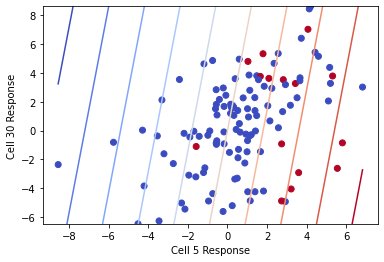

In [48]:

# Get the responses of the selected cells

cell1_responses = selected_responses.loc[:, cells_index[0]]
cell2_responses = selected_responses.loc[:, cells_index[1]]
plt.scatter(cell1_responses, cell2_responses, c=y, cmap='coolwarm')

# Add a line showing the dividing line from the parameters of the classifier
coef = model.coef_[0]

x_line = np.linspace(cell1_responses.min(), cell1_responses.max(), 100)

n = 10  # number of colors
# Get coolwarm colormap
cmap = plt.cm.coolwarm
# Generate a list of n colors from cool to warm
colors = [cmap(i) for i in np.linspace(0, 1, n)]

for i in range(n):
    y_line = ((i-n/2) - coef[0] * x_line) / coef[1]
    plt.plot(x_line, y_line, color=colors[i])

# Set the labels and title
plt.xlabel(f'Cell {cells_index[0]} Response')
plt.ylabel(f'Cell {cells_index[1]} Response')
plt.ylim(cell2_responses.min(), cell2_responses.max())
# Show the plot
plt.show()

## Classifying all orientations

TODO: add text

In [49]:
y = stim_table.loc[selected_sweeps, 'orientation']
model.fit(X, y)
model.score(X, y)

0.2833333333333333

In [50]:
X = selected_responses
model.fit(X, y)
model.score(X, y)

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


1.0

Discuss: Does anything seem odd to you about this result? Let's discuss why this may not be as perfect as it seems.

## Splitting training and test data

Our ultimate goal is a model that captures **true** patterns in the data, but what does "true" mean here? One way of resolving this scientifically would be to experiment: generate more data from the same cells and see if the same patterns are present (if the estimator can predict the stimuli well on the new data). Practically, we can't usually repeat experiments like this, but we can instead hide some of the existing data during the *fit* step and use it only to predict and evaluate. We call the fit data the training dataset, and the hidden data the test dataset.

Sklearn has a method to shuffle the data (across trials) and make this split randomly `train_test_split`.

Discuss: Why might shuffling be important here?

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)


In [52]:
# Ex:
# Fit the model on the training data, predict the binary indicator for the test data, and calculate the accuracy
model.fit(X_train, y_train)
model.score(X_test, y_test)


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8

This is not so great - let's pay attention to this warning and add one step to our process to see if we can improve performance

In [53]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model = make_pipeline(StandardScaler(), LogisticRegression())

In [54]:
model.fit(X_train, y_train)
model.score(X_test, y_test)


0.8

This is getting better! Let's also visualize a confusion matrix of the pattern of errors. Sklearn has a built-in method for this - try out the function `ConfusionMatrixDisplay.from_estimator()`

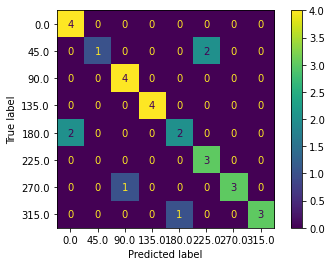

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay

cm_display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

## Temporal frequency and decoding

In [56]:
X = mean_sweep_response
y = stim_table['orientation']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)


In [57]:
model.fit(X_train, y_train)
model.score(X_test, y_test)


0.8

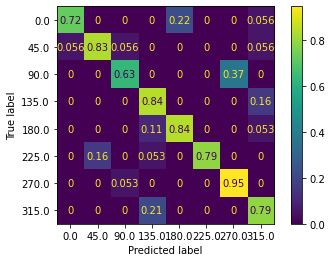

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay

cm_display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test , normalize='true')

In this case, decoding seems better when we include all temporal frequencies. We can even begin to see a pattern in the errors from the confusion matrix plot.

Discuss: what do you think this pattern means?

## Classifier for both TF & orientation

We've seen that decoding can do fairly well with all the data, not knowing about the temporal frequency at all. Is it possible we could increase performance even more by training on both orientation and temporal frequency labels together? A few classifiers in sklearn can function in the *multi-output* context where we pass a 2D matrix of target data instead of a vector. We'll test out one of these, the random forest classifier.

In [96]:
from sklearn.ensemble import RandomForestClassifier

# Ex: Define the target variable and the feature matrix, and run the train_test_split function
X = mean_sweep_response
Y = stim_table[['temporal_frequency', 'orientation']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25, random_state=42)

# Ex: Create an instance of the Random Forest model, fit the model, and predict the target variable
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [102]:
# we can't use model.score in this context, so instead generate a prediction of the target variables,
# and evaluate accuracy separately each one, using the accuracy_score function
from sklearn.metrics import accuracy_score

print("temporal frequency accuracy: ", accuracy_score(y_test.values[:,0], y_pred[:,0]))
print("orientation accuracy: ", accuracy_score(y_test.values[:,1], y_pred[:,1]))

temporal frequency accuracy:  0.38666666666666666
orientation accuracy:  0.8333333333333334


This is similar to before, but is it actually better? How much does performance vary run to run? As implied in the name, the random forest classifier has an element of randomness in its performance.

We should also compare to the same classifier's performance on orientation data only.

In [126]:
# Ex: repeat the above process with orientation data only in Y
X = mean_sweep_response
Y = stim_table['orientation']
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25, random_state=42)


model.fit(X_train, y_train)
model.score(X_test, y_test)


0.7866666666666666

## Extra: using cross-validation to get better estimates of accuracy

In [127]:
from sklearn.model_selection import cross_val_predict, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Ex: Calculate the cross-validated accuracy of the model
y_pred = cross_val_predict(model, X, Y, cv=cv)
print("accuracy: ", accuracy_score(Y, y_pred))

accuracy:  0.7595993322203672


In [128]:
Y = stim_table[['temporal_frequency', 'orientation']]

y_pred = cross_val_predict(model, X, Y, cv=cv)
print("temporal frequency accuracy: ", accuracy_score(Y.values[:,0], y_pred[:,0]))
print("orientation accuracy: ", accuracy_score(Y.values[:,1], y_pred[:,1]))

temporal frequency accuracy:  0.34390651085141904
orientation accuracy:  0.7729549248747913


## Exercise: train a classifier on two natural images